# Astroquery examples

In [1]:
# import statements
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView

import numpy as np
import astropy.coordinates as coord
from astropy import units as u

## Looking at M31

Let use simbad to get the position of m31 then use ViZier to get an image of M31.

In [2]:
# lets look at M31
result = Simbad.query_object('m31')
# get SkyCoord for m31
m31 = coord.SkyCoord(result['RA'][0], result['DEC'][0],
                     frame='icrs', unit=(u.deg, u.deg))
# Query vizier for catalogues containing this position
m31_tables = Vizier.query_region(m31, radius=5*u.arcsec)
# Use sky view to get the image
m31_fits = SkyView.get_images(position='m31',
                              coordinates='icrs',
                              survey=['DSS'], 
                              pixels=1500)
m31_image = m31_fits[0][0].data


 [Done]


These are the tables found:

In [4]:
m31_tables.print_table_list()

print('\nFirst table:  \n\n')
print(m31_tables[0])

TableList with 7 tables:
	'0:I/284/out' with 14 column(s) and 1 row(s) 
	'1:I/297/out' with 19 column(s) and 1 row(s) 
	'2:I/305/out' with 11 column(s) and 1 row(s) 
	'3:I/324/igsl3' with 18 column(s) and 1 row(s) 
	'4:II/311/wise' with 22 column(s) and 1 row(s) 
	'5:II/328/allwise' with 28 column(s) and 1 row(s) 
	'6:II/349/ps1' with 35 column(s) and 2 row(s) 

First table:  


 USNO-B1.0    RAJ2000    DEJ2000   e_RAJ2000 ... R1mag B2mag R2mag  Imag
                deg        deg        mas    ...  mag   mag   mag   mag 
------------ ---------- ---------- --------- ... ----- ----- ----- -----
1312-0000959   0.713087  41.269317       260 ...    -- 20.77 19.74 18.45


Then we can plot the SkyView image

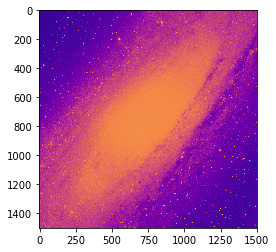

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

im = plt.imshow(m31_image, cmap='plasma')

## Exoplanet Catalogue

First import modules:

In [35]:
from astroquery import open_exoplanet_catalogue as oec
from astropy.table import Table
import numpy as np

Then we need to get the data in a usable form:

In [50]:
# get raw catalogue
rd = oec.get_catalogue()

def isfloat(value):
    try:
        float(value)
        return True
    except (ValueError, TypeError) as e:
        return False

# extract data from database
def get_exo_database():
    # extract columns from database
    columns, floats = dict(), dict()
    for planet in rd.findall(".//planet"):
        raw = oec.xml_element_to_dict(planet)
        # loop around the columns
        for col in raw.keys():
            columns[col] = col
            if col in floats:
                if not floats[col]:
                    floats[col] = isfloat(raw[col].strip())
            else:
                floats[col] = isfloat(raw[col])

    columns = list(columns.keys())
    floats = list(floats.values())
    #  push data into a dictionary then store in a table
    datadict = dict()
    # add columns
    for col in columns:
        datadict[col] = []
    # loop around planets and add to datadict
    for planet in rd.findall(".//planet"):
        raw = oec.xml_element_to_dict(planet)
        # loop around columns
        for c, col in enumerate(columns):
            if col in list(raw.keys()):
                if floats[c]:
                    try:
                        datadict[col].append(float(raw[col]))
                    except (ValueError, TypeError) as e:
                        datadict[col].append(np.nan)
                else:
                    datadict[col].append(raw[col])
            else:
                if floats[c]:
                    datadict[col].append(np.nan)
                else:
                    datadict[col].append('')
    # finally convert datadict into table
    table = Table()
    for col in columns:
        table[col] = datadict[col]
    # return table for use
    return table

In [69]:
# get database
db = get_exo_database()
# get mass and semi-major axis
mass = np.array(db['mass'])
sma = np.array(db['semimajoraxis'])
dis = np.array(db['discoverymethod'])
# mask nans
mask = np.isfinite(mass) & np.isfinite(sma)
mass, sma, dis = mass[mask], sma[mask], dis[mask]
# get categories
dcat = ['RV', 'imaging', 'microlensing', 'timing', 'transit']
dcol = ['g', 'r', 'c', 'orange', 'b']
dmasks = []
for cat in dcat:
    dmasks.append(dis == cat)

Now we can use the data:

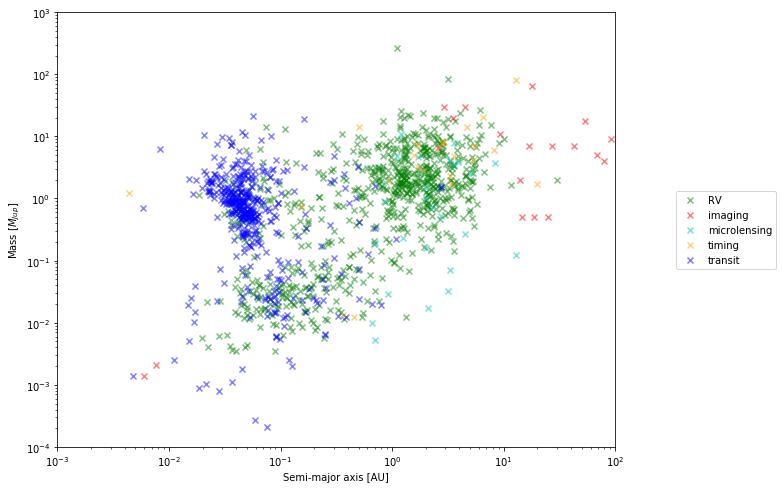

In [81]:
# set up figure
fig = plt.figure(figsize=(10, 8))
frame = plt.subplot(111)
# plot mass against period
for dit, dmask in enumerate(dmasks):
    frame.scatter(sma[dmask], mass[dmask], color=dcol[dit], marker='x',
                  label=dcat[dit], alpha=0.5)
# finalise graph
frame.set(xlabel='Semi-major axis [AU]', 
          ylabel='Mass [$M_{Jup}$]',
          xlim=(0.001, 100), ylim=(0.0001, 1000))
_ = frame.set_xscale('log'), frame.set_yscale('log')
# legend
legend = frame.legend(loc=6, bbox_to_anchor=(1.1, 0.5))


### Sources

- [Astroquery Gallery](http://astroquery.readthedocs.io/en/latest/gallery.html)

- [Astropy SkyCoords](http://docs.astropy.org/en/stable/coordinates/skycoord.html)

- [The Open Exoplanet Catalogue ](https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue)